In [1]:
import numpy as np
import math
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from rouge_score import rouge_scorer

# Preprocessing setup
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return tokens

# Example documents
documents = [
    "What’s the point of crazy new ideas when politicians can’t even manage to balance a budget? Can new ideas genuinely change the world? Now, your (very reasonable) gut response might be: They can’t - people will stubbornly stick to the old ideas that they’re comfortable with. The thing is, we know that ideas have changed over time. Yesterday’s avant-garde is today’s common sense. Simon Kuznets willed the idea of the GDP into being. The randomistas upset the apple cart of foreign aid by forcing it to prove its efficacy. The question is not can new ideas defeat old ones; the question is how.",
    "Research suggests that sudden shocks can work wonders. James Kuklinski, a political scientist at the University of Illinois, discovered that people are most likely to change their opinions if you confront them with new and disagreeable facts as directly as possible. Take the success of right-wing politicians who were already warning of “the Islamic threat” back in the 1990s, but didn’t get much attention until the shocking destruction of the Twin Towers on September 11, 2001. Viewpoints that had once been fringe suddenly became a collective obsession.",
    "If it is true that ideas don’t change things gradually but in fits and starts - in shocks - then the basic premise of our democracy, our journalism, and our education is all wrong. It would mean, in essence, that the Enlightenment model of how people change their opinions - through information-gathering and reasoned deliberation - is really a buttress for the status quo. It would mean that those who swear by rationality, nuance, and compromise fail to grasp how ideas govern the world. A worldview is not a Lego set where a block is added here, removed there. It’s a fortress that is defended tooth and nail, with all possible reinforcements, until the pressure becomes so overpowering that the walls cave in.",
    "American psychologist Solomon Asch demonstrated that group pressure can even cause us to ignore what we can plainly see with our own eyes. In a now-famous experiment, he showed test subjects three lines on a card and asked them which one was longest. When the other people in the room (all Asch’s coworkers, unbeknownst to the subject) gave the same answer, the subject did, too - even when it was clearly erroneous. It’s no different in politics. Political scientists have established that how people vote is determined less by their perceptions about their own lives than by their conceptions of society. We’re not particularly interested in what government can do for us personally; we want to know what it can do for us all. When we cast our vote, we do so not just for ourselves, but for the group we want to belong to.",
    "But Solomon Asch made another discovery. A single opposing voice can make all the difference. When just one other person in the group stuck to the truth, the test subjects were more likely to trust the evidence of their own senses. Let this be an encouragement to all those who feel like a lone voice crying out in the wilderness: Keep on building those castles in the sky. Your time will come."
]

processed_texts = [preprocess(doc) for doc in documents]
processed_text = [word for sublist in processed_texts for word in sublist]
vocabulary = list(set(processed_text))
vocab_len = len(vocabulary)

# Cosine Similarity
vectorizer = TfidfVectorizer(vocabulary=vocabulary)
X = vectorizer.fit_transform([' '.join(processed_text)])
tfidf_matrix = X.toarray()

cosine_weighted_edge = np.zeros((vocab_len, vocab_len), dtype=np.float32)
for i in range(vocab_len):
    for j in range(vocab_len):
        if i != j:
            dot_product = np.dot(tfidf_matrix[:, i], tfidf_matrix[:, j])
            norm_i = np.linalg.norm(tfidf_matrix[:, i])
            norm_j = np.linalg.norm(tfidf_matrix[:, j])
            if norm_i != 0 and norm_j != 0:
                cosine_weighted_edge[i][j] = dot_product / (norm_i * norm_j)

# Jaccard Similarity
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

jaccard_weighted_edge = np.zeros((vocab_len, vocab_len), dtype=np.float32)
for i in range(vocab_len):
    for j in range(vocab_len):
        if i != j:
            set_i = set([idx for idx, text in enumerate(processed_texts) if vocabulary[i] in text])
            set_j = set([idx for idx, text in enumerate(processed_texts) if vocabulary[j] in text])
            jaccard_weighted_edge[i][j] = jaccard_similarity(set_i, set_j)

# TF-IDF
tfidf_weighted_edge = np.zeros((vocab_len, vocab_len), dtype=np.float32)
for i in range(vocab_len):
    for j in range(vocab_len):
        if i != j:
            tfidf_weighted_edge[i][j] = tfidf_matrix[0][i] * tfidf_matrix[0][j]

# Co-occurrence
window_size = 3
cooccurrence_weighted_edge = np.zeros((vocab_len, vocab_len), dtype=np.float32)
for window_start in range(len(processed_text) - window_size + 1):
    window = processed_text[window_start:window_start + window_size]
    for i in range(window_size):
        for j in range(window_size):
            if i != j:
                index_i = vocabulary.index(window[i])
                index_j = vocabulary.index(window[j])
                cooccurrence_weighted_edge[index_i][index_j] += 1 / abs(i - j)

# TextRank Algorithm
def run_textrank(weighted_edge):
    score = np.ones(vocab_len, dtype=np.float32)
    MAX_ITERATIONS = 50
    d = 0.85
    threshold = 0.0001

    for _ in range(MAX_ITERATIONS):
        prev_score = np.copy(score)
        for i in range(vocab_len):
            summation = 0
            for j in range(vocab_len):
                if weighted_edge[i][j] != 0:
                    summation += (weighted_edge[i][j] / np.sum(weighted_edge[:, j])) * score[j]
            score[i] = (1 - d) + d * summation
        if np.sum(np.abs(prev_score - score)) <= threshold:
            break
    return score

cosine_scores = run_textrank(cosine_weighted_edge)
jaccard_scores = run_textrank(jaccard_weighted_edge)
tfidf_scores = run_textrank(tfidf_weighted_edge)
cooccurrence_scores = run_textrank(cooccurrence_weighted_edge)

# Extract Keywords
def extract_keywords(scores, top_n=10):
    sorted_indices = np.argsort(scores)[::-1]
    keywords = [vocabulary[i] for i in sorted_indices[:top_n]]
    return keywords

cosine_keywords = extract_keywords(cosine_scores)
jaccard_keywords = extract_keywords(jaccard_scores)
tfidf_keywords = extract_keywords(tfidf_scores)
cooccurrence_keywords = extract_keywords(cooccurrence_scores)

print("Cosine Keywords:", cosine_keywords)
print("Jaccard Keywords:", jaccard_keywords)
print("TF-IDF Keywords:", tfidf_keywords)
print("Co-occurrence Keywords:", cooccurrence_keywords)

# Evaluate Performance
reference_keywords = ["idea", "change", "world", "people", "politician", "fact", "group", "research", "opinion", "democracy"]
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

def evaluate_keywords(extracted_keywords):
    reference = ' '.join(reference_keywords)
    extracted = ' '.join(extracted_keywords)
    scores = scorer.score(reference, extracted)
    return scores

cosine_evaluation_scores = evaluate_keywords(cosine_keywords)
jaccard_evaluation_scores = evaluate_keywords(jaccard_keywords)
tfidf_evaluation_scores = evaluate_keywords(tfidf_keywords)
cooccurrence_evaluation_scores = evaluate_keywords(cooccurrence_keywords)

print("Cosine ROUGE Scores:", cosine_evaluation_scores)
print("Jaccard ROUGE Scores:", jaccard_evaluation_scores)
print("TF-IDF ROUGE Scores:", tfidf_evaluation_scores)
print("Co-occurrence ROUGE Scores:", cooccurrence_evaluation_scores)


Cosine Keywords: ['eye', 'attention', 'building', 'essence', 'prove', 'sens', 'cave', 'society', 'suddenly', 'conception']
Jaccard Keywords: ['people', 'change', 'pressure', 'scientist', 'political', 'even', 'know', 'one', 'shock', 'opinion']
TF-IDF Keywords: ['idea', 'people', 'change', 'new', 'subject', 'even', 'group', 'one', 'asch', 'possible']
Co-occurrence Keywords: ['idea', 'people', 'new', 'subject', 'change', 'u', 'one', 'asch', 'even', 'group']
Cosine ROUGE Scores: {'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
Jaccard ROUGE Scores: {'rouge1': Score(precision=0.3, recall=0.3, fmeasure=0.3), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.2, recall=0.2, fmeasure=0.20000000000000004)}
TF-IDF ROUGE Scores: {'rouge1': Score(precision=0.4, recall=0.4, fmeasure=0.4000000000000001), 'rouge2': Score(precision=0.0, recall

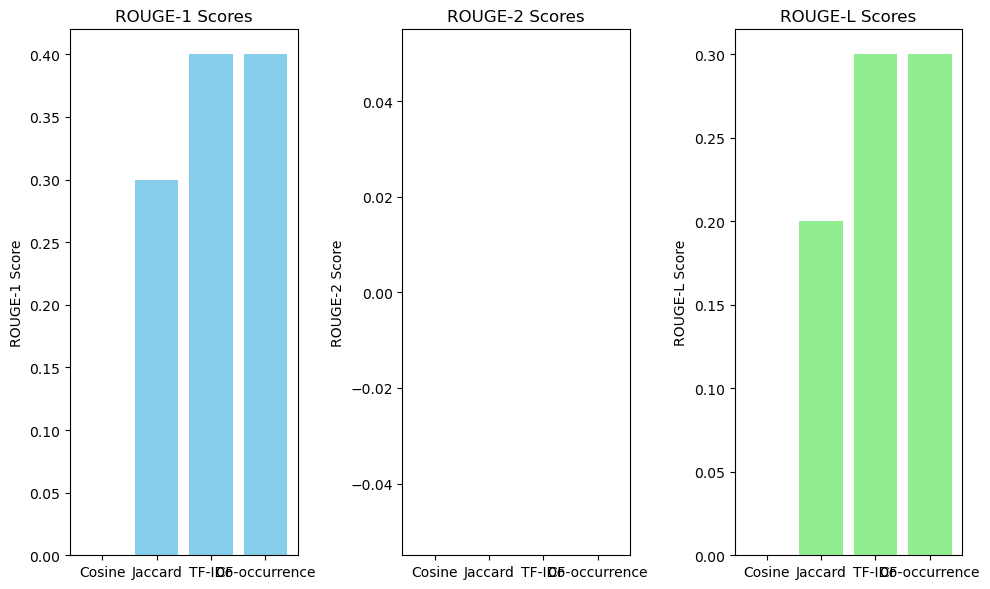

In [2]:
import matplotlib.pyplot as plt

methods = ['Cosine', 'Jaccard', 'TF-IDF', 'Co-occurrence']
rouge1_scores = [cosine_evaluation_scores['rouge1'][0], jaccard_evaluation_scores['rouge1'][0], tfidf_evaluation_scores['rouge1'][0], cooccurrence_evaluation_scores['rouge1'][0]]
rouge2_scores = [cosine_evaluation_scores['rouge2'][0], jaccard_evaluation_scores['rouge2'][0], tfidf_evaluation_scores['rouge2'][0], cooccurrence_evaluation_scores['rouge2'][0]]
rougeL_scores = [cosine_evaluation_scores['rougeL'][0], jaccard_evaluation_scores['rougeL'][0], tfidf_evaluation_scores['rougeL'][0], cooccurrence_evaluation_scores['rougeL'][0]]

plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 1)
plt.bar(methods, rouge1_scores, color='skyblue')
plt.title('ROUGE-1 Scores')
plt.ylabel('ROUGE-1 Score')

plt.subplot(1, 3, 2)
plt.bar(methods, rouge2_scores, color='salmon')
plt.title('ROUGE-2 Scores')
plt.ylabel('ROUGE-2 Score')

plt.subplot(1, 3, 3)
plt.bar(methods, rougeL_scores, color='lightgreen')
plt.title('ROUGE-L Scores')
plt.ylabel('ROUGE-L Score')

plt.tight_layout()
plt.show()
